In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import warnings

warnings.filterwarnings('ignore')

In [79]:
def calculate_inflation_rate(df):
    """Calculate inflation rate from CPI data"""
    df = df.copy()
    df['Inflation_Rate'] = df['All_Items CPI'].pct_change() * 100
    df = df.dropna()
    return df

In [80]:
def create_features(df):
    df = df.copy()

    # Lagged features
    df['CPI_lag1'] = df['All_Items CPI'].shift(1)
    df['CPI_lag2'] = df['All_Items CPI'].shift(2)
    df['Inflation_lag1'] = df['Inflation_Rate'].shift(1)
    df['Inflation_lag2'] = df['Inflation_Rate'].shift(2)

    # Economic indicators
    df['Exchange_Rate_change'] = df['Exchange_Rate'].pct_change()
    df['GDP_growth'] = df['GDP'].pct_change()
    df['Interest_Rate_change'] = df['Interest_Rate'].diff()
    df['Money_Supply_growth'] = df['Money_Supply'].pct_change()
    
    # Moving averages
    df['CPI_MA3'] = df['All_Items CPI'].rolling(window=3).mean()
    df['Exchange_Rate_MA3'] = df['Exchange_Rate'].rolling(window=3).mean()
    
    # Volatility measures
    df['CPI_volatility'] = df['All_Items CPI'].rolling(window=4).std()
    df['Exchange_Rate_volatility'] = df['Exchange_Rate'].rolling(window=4).std()

    return df

In [81]:
def prepare_model_data(df):
    """Prepare features and target for modeling"""
    # Select feature columns
    feature_cols = [
        # 'CPI_lag1', 'CPI_lag2', 'Inflation_lag1', 'Inflation_lag2',
        'Exchange_Rate', 'Exchange_Rate_change', 'GDP_growth',
        'Interest_Rate', 'Interest_Rate_change', 'Money_Supply_growth',
        # 'CPI_MA3', 'Exchange_Rate_MA3', 'CPI_volatility', 'Exchange_Rate_volatility'
    ]

    df_clean = df.dropna()

    X = df_clean[feature_cols]
    y = df_clean['Inflation_Rate']

    return X, y, df_clean

In [82]:
# ========== UTILITY FUNCTIONS ==========

def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {'Model': model_name, 'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R²': r2}

def plot_predictions(y_true, predictions_dict, dates):
    plt.figure(figsize=(15, 10))
    plt.plot(dates, y_true, label='Actual', linewidth=3, marker='o')
    for name, pred in predictions_dict.items():
        plt.plot(dates, pred, label=name + ' Predicted', linestyle='--')
    plt.title('Inflation Rate: Actual vs Predicted')
    plt.xlabel('Date'); plt.ylabel('Inflation Rate (%)')
    plt.legend(); plt.xticks(rotation=45)
    plt.grid(True); plt.tight_layout(); plt.show()

def plot_feature_importance_comparison(importance_dict, top_n=10):
    fig, axes = plt.subplots(1, len(importance_dict), figsize=(20, 6))
    for i, (model_name, importance) in enumerate(importance_dict.items()):
        sorted_features = sorted(importance.items(), key=lambda x: abs(x[1]), reverse=True)[:top_n]
        features, values = zip(*sorted_features)
        axes[i].barh(range(len(features)), values)
        axes[i].set_yticks(range(len(features)))
        axes[i].set_yticklabels(features)
        axes[i].invert_yaxis()
        axes[i].set_title(f'{model_name} Feature Importance')
    plt.tight_layout(); plt.show()

In [83]:
# ========== MODEL WRAPPERS ==========

class BaseModel:
    def __init__(self, model, scaler=None):
        self.model = model
        self.scaler = scaler
        self.is_fitted = False

    def fit(self, X, y):
        if self.scaler:
            X = self.scaler.fit_transform(X)
        self.model.fit(X, y)
        self.is_fitted = True

    def predict(self, X):
        if not self.is_fitted:
            raise Exception("Model not fitted")
        if self.scaler:
            X = self.scaler.transform(X)
        return self.model.predict(X)

    def get_feature_importance(self, feature_names):
        if hasattr(self.model, 'coef_'):
            return dict(zip(feature_names, self.model.coef_))
        elif hasattr(self.model, 'feature_importances_'):
            return dict(zip(feature_names, self.model.feature_importances_))
        else:
            return dict(zip(feature_names, [0] * len(feature_names)))

In [84]:
# ========== HYPERPARAMETER TUNING ==========

def tune_lasso(X_train, y_train):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train)
    lasso = Lasso(random_state=42)
    grid = GridSearchCV(lasso, {'alpha': [0.001, 0.01, 0.1, 1, 10]}, cv=5, scoring='neg_mean_squared_error')
    grid.fit(X_scaled, y_train)
    return BaseModel(grid.best_estimator_, scaler), grid.best_params_

def tune_ridge(X_train, y_train):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train)
    ridge = Ridge(random_state=42)
    grid = GridSearchCV(ridge, {'alpha': [0.001, 0.01, 0.1, 1, 10]}, cv=5, scoring='neg_mean_squared_error')
    grid.fit(X_scaled, y_train)
    return BaseModel(grid.best_estimator_, scaler), grid.best_params_

def tune_rf(X_train, y_train):
    rf = RandomForestRegressor(random_state=42)
    params = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt', 'log2']
    }
    search = RandomizedSearchCV(rf, params, cv=5, n_iter=30, n_jobs=-1, scoring='neg_mean_squared_error')
    search.fit(X_train, y_train)
    return BaseModel(search.best_estimator_), search.best_params_

def tune_xgb(X_train, y_train):
    xgb_model = xgb.XGBRegressor(random_state=42, eval_metric='rmse')
    params = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 6],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
    search = RandomizedSearchCV(xgb_model, params, cv=5, n_iter=30, n_jobs=-1, scoring='neg_mean_squared_error')
    search.fit(X_train, y_train)
    return BaseModel(search.best_estimator_), search.best_params_


=== BASELINE MODELS ===

=== TUNED MODELS ===

=== MODEL PERFORMANCE ===
                   Model     MAE     MSE    RMSE      R²
4                  Ridge  0.4360  0.3490  0.5907 -0.0699
3                  Lasso  0.4295  0.3499  0.5916 -0.0728
0      Linear Regression  0.4542  0.3539  0.5949 -0.0851
5  Random Forest (Tuned)  0.8946  1.1032  1.0503 -2.3820
1   Random Forest (Base)  0.9416  1.2002  1.0956 -2.6796
6        XGBoost (Tuned)  0.9653  1.2759  1.1296 -2.9116
2         XGBoost (Base)  1.0002  1.3389  1.1571 -3.1047


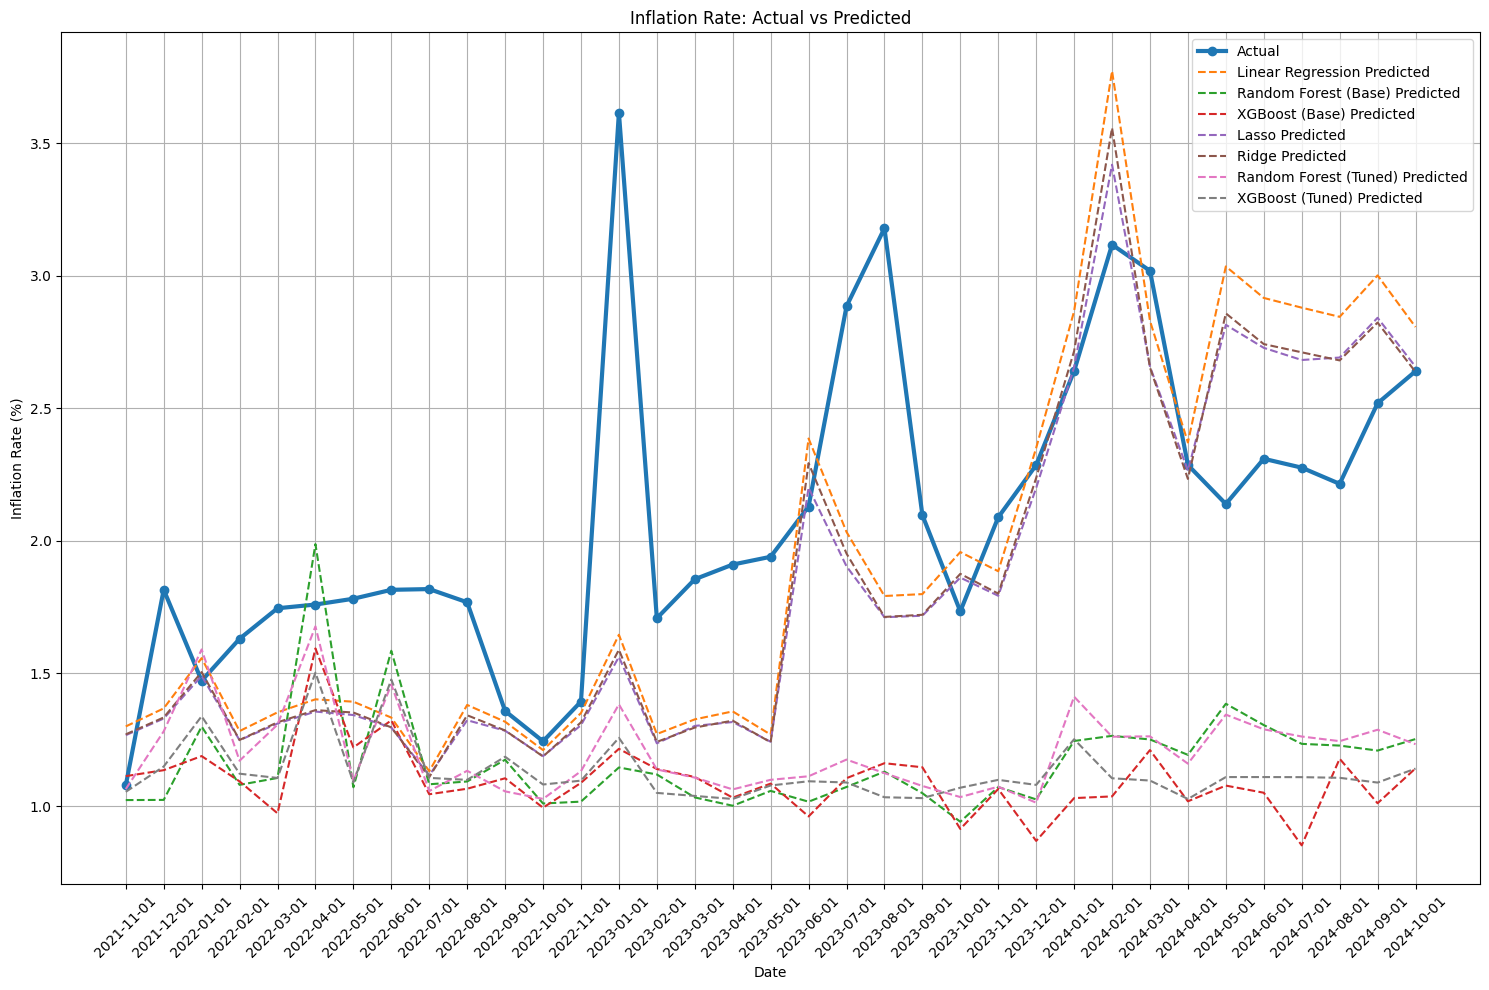

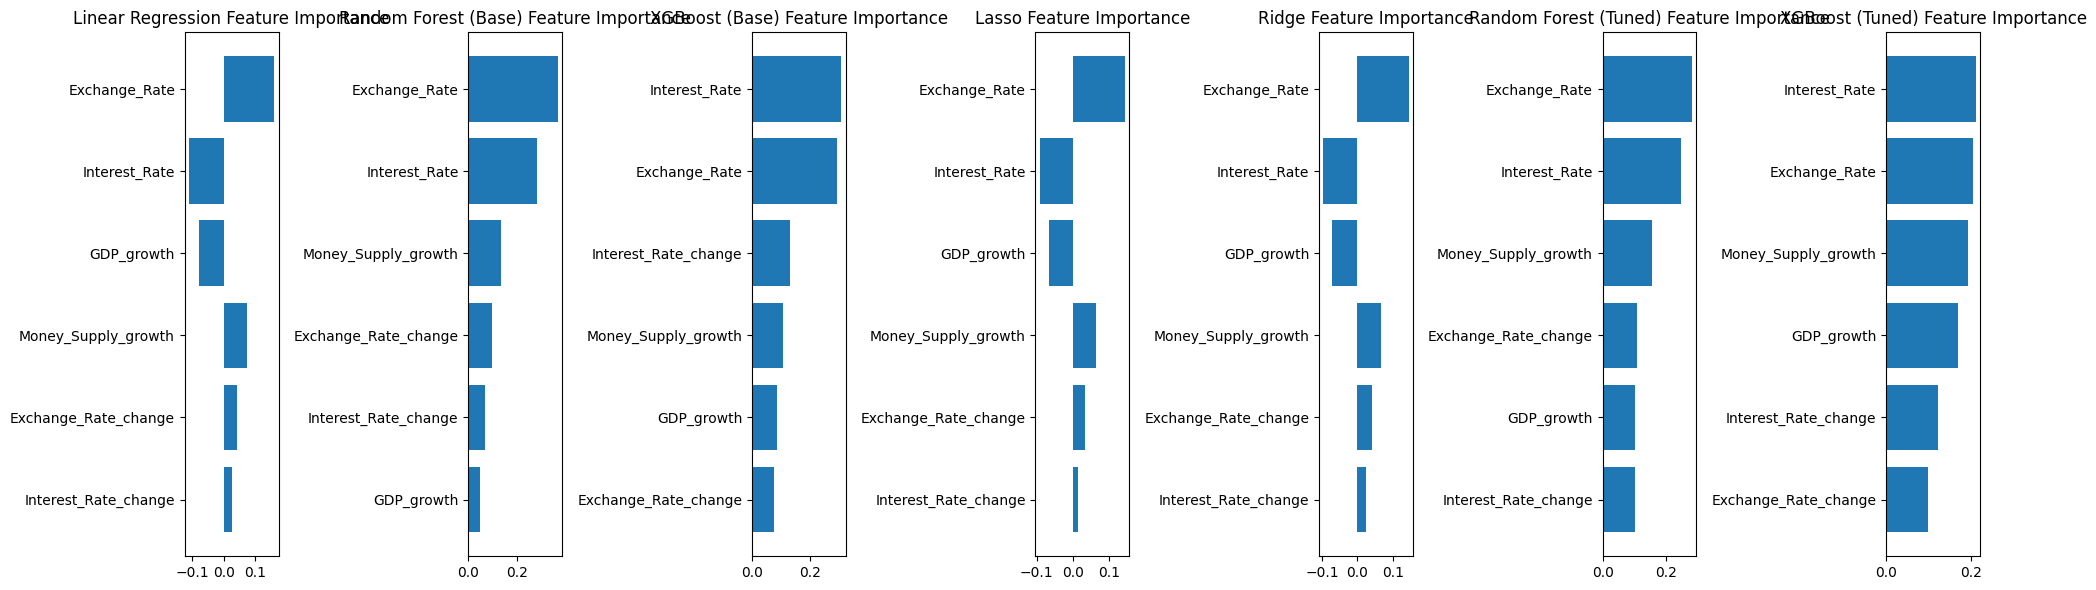

In [85]:
# ========== MAIN EXECUTION FUNCTION ==========

def run_pipeline():
    # Load and process data
    df = pd.read_csv('clarified_cleaned_datasets/economic_indicators.csv')
    df = calculate_inflation_rate(df)
    df = create_features(df)
    X, y, df_clean = prepare_model_data(df)
    dates = df_clean['Date']

    # Time-based train/test split
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    test_dates = dates.iloc[split_idx:]
    features = list(X.columns)

    # Baseline models
    print("\n=== BASELINE MODELS ===")
    baseline_models = {
        'Linear Regression': BaseModel(LinearRegression(), StandardScaler()),
        'Random Forest (Base)': BaseModel(RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)),
        'XGBoost (Base)': BaseModel(xgb.XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42))
    }

    tuned_models = {}

    # Train and evaluate baseline models
    baseline_results, baseline_preds, baseline_importance = [], {}, {}
    for name, model in baseline_models.items():
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        baseline_preds[name] = pred
        baseline_results.append(evaluate_model(y_test, pred, name))
        baseline_importance[name] = model.get_feature_importance(features)

    # Tune and evaluate
    print("\n=== TUNED MODELS ===")
    tuned_models['Lasso'], lasso_params = tune_lasso(X_train, y_train)
    tuned_models['Ridge'], ridge_params = tune_ridge(X_train, y_train)
    tuned_models['Random Forest (Tuned)'], rf_params = tune_rf(X_train, y_train)
    tuned_models['XGBoost (Tuned)'], xgb_params = tune_xgb(X_train, y_train)

    tuned_results, tuned_preds, tuned_importance = [], {}, {}
    for name, model in tuned_models.items():
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        tuned_preds[name] = pred
        tuned_results.append(evaluate_model(y_test, pred, name))
        tuned_importance[name] = model.get_feature_importance(features)

    # Results DataFrames
    all_results_df = pd.DataFrame(baseline_results + tuned_results)
    print("\n=== MODEL PERFORMANCE ===")
    print(all_results_df.sort_values(by='R²', ascending=False).round(4))

    # Plots
    all_preds = {**baseline_preds, **tuned_preds}
    all_importance = {**baseline_importance, **tuned_importance}

    plot_predictions(y_test, all_preds, test_dates)
    plot_feature_importance_comparison(all_importance)

    return all_results_df, baseline_models, tuned_models

# RUN
results_df, baseline_models, tuned_models = run_pipeline()

In [86]:
results_df

,Model,MAE,MSE,RMSE,R²
0,Linear Regression,0.454211,0.353938,0.594927,-0.085088
1,Random Forest (Base),0.941552,1.200241,1.095555,-2.679645
2,XGBoost (Base),1.000169,1.338898,1.157107,-3.104731
3,Lasso,0.429485,0.349937,0.591555,-0.072821
4,Ridge,0.435952,0.348971,0.590738,-0.069860
5,Random Forest (Tuned),0.894583,1.103168,1.050318,-2.382042
6,XGBoost (Tuned),0.965324,1.275914,1.129564,-2.911639


In [87]:
# Lasso Regression performs well